In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm.sklearn import LGBMRegressor

In [4]:
factors = ['Beta60', 'OperatingRevenueGrowRate', 'NetProfitGrowRate', 'NetCashFlowGrowRate', 'NetProfitGrowRate5Y', 'TVSTD20',
           'TVSTD6', 'TVMA20', 'TVMA6', 'BLEV', 'MLEV', 'CashToCurrentLiability', 'CurrentRatio', 'REC', 'DAREC', 'GREC',
           'DASREV', 'SFY12P', 'LCAP', 'ASSI', 'LFLO', 'TA2EV', 'PEG5Y', 'PE', 'PB', 'PS', 'SalesCostRatio', 'PCF', 'CETOP',
           'TotalProfitGrowRate', 'CTOP', 'MACD', 'DEA', 'DIFF', 'RSI', 'PSY', 'BIAS10', 'ROE', 'ROA', 'ROA5', 'ROE5',
           'DEGM', 'GrossIncomeRatio', 'ROECut', 'NIAPCut', 'CurrentAssetsTRate', 'FixedAssetsTRate', 'FCFF', 'FCFE', 'PLRC6',
           'REVS5', 'REVS10', 'REVS20', 'REVS60', 'HSIGMA', 'HsigmaCNE5', 'ChaikinOscillator', 'ChaikinVolatility', 'Aroon',
           'DDI', 'MTM', 'MTMMA', 'VOL10', 'VOL20', 'VOL5', 'VOL60', 'RealizedVolatility', 'DASTD', 'DDNSR', 'Hurst']

df = pd.read_csv('dataset_factorRank10.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,ticker,tradeDate,Beta60,OperatingRevenueGrowRate,NetProfitGrowRate,NetCashFlowGrowRate,NetProfitGrowRate5Y,TVSTD20,...,RealizedVolatility,DASTD,DDNSR,Hurst,next_month_end,abs_return,active_return,industryName1,label,year
0,0,0,1,20070131,9,8,1,8,6,3,...,10,8,10,10,20070228,-0.004221,-0.071021,银行,-1,2007
1,1,1,2,20070131,3,3,5,5,9,2,...,10,3,9,10,20070228,-0.037359,-0.104159,房地产,-1,2007
2,2,2,60,20070131,1,8,1,4,1,1,...,10,2,3,10,20070228,0.171481,0.104681,有色金属,0,2007
3,3,3,63,20070131,7,9,9,1,5,1,...,10,8,8,10,20070228,0.093903,0.027103,通信,0,2007
4,4,4,69,20070131,9,5,9,4,3,1,...,10,3,3,10,20070228,0.020656,-0.046144,房地产,-1,2007


In [22]:
import time
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('dataset_factorRank10.csv')

def get_train_val_test_data(df, year):
    back_year = max(2007, year-6)
    train_df = df[(df['year']>=back_year) & (df['year']<year)]
    
    test_df = df[df['year']==year]
    
    return train_df, test_df


def format_feature_label(origin_df):
    feature = np.array(origin_df[factors])
    label = np.array(origin_df['abs_return'])

    return feature, label

def write_factor_to_csv(df, predict_score, year, filename):  
    df.loc[:,'factor'] = predict_score
    df = df.loc[:, ['ticker', 'tradeDate', 'abs_return', 'factor']]
    is_header = True
    if year != 2011:
        is_header = False
    
    df.to_csv(filename, mode='a+', encoding='utf-8', header=is_header)

def get_rf_result(train_data, train_label, test_data): #model 4
    lgb = LGBMRegressor(max_depth = 5,
                    learning_rate = 0.01,
                    n_estimators = 266,
                    min_child_weight = 4, 
                    gamma = 0.11 ,
                    subsample =0.75,
                    colsample_bytree = 0.5,
                    reg_alpha = 0.30,
                    min_gain_to_split = 0.4,
                    n_jobs = 10,
                    verbose = 0)
    lgb.fit(train_data, train_label,eval_metric='auc', verbose = 0)
    predict_score = lgb.predict(test_data)

    return predict_score

def pipeline():
    '''
    对7个阶段分别进行训练测试，并保存测试的因子合成值
    返回:
        boost_model_list, list结构，每个阶段汇总的模型集合
    '''
    t0 = time.time()
    linear_file = "lgbr_abs.csv"
    
    for year in range(2011,2018):#range(2011, 2018)
        print('training model for %s' % year)
        t1 = time.time()
        #构建训练测试数据x
        train_df, test_df = get_train_val_test_data(df, year)
        train_feature, train_label = format_feature_label(train_df)
        test_feature, test_label = format_feature_label(test_df)

        predict_score = get_rf_result(train_feature, train_label, test_feature)
        write_factor_to_csv(test_df, predict_score, year, linear_file)

        print('------------------ finish year: %s, time cost: %s seconds--------------' % (year, time.time() - t1))

    print('Done, Time cost: %s seconds' % (time.time() - t0))
pipeline()  

training model for 2011
------------------ finish year: 2011, time cost: 0.6643886566162109 seconds--------------
training model for 2012
------------------ finish year: 2012, time cost: 0.7484674453735352 seconds--------------
training model for 2013
------------------ finish year: 2013, time cost: 0.8544847965240479 seconds--------------
training model for 2014
------------------ finish year: 2014, time cost: 0.8396687507629395 seconds--------------
training model for 2015
------------------ finish year: 2015, time cost: 0.8065600395202637 seconds--------------
training model for 2016
------------------ finish year: 2016, time cost: 0.9027965068817139 seconds--------------
training model for 2017
------------------ finish year: 2017, time cost: 0.9642984867095947 seconds--------------
Done, Time cost: 5.781306505203247 seconds


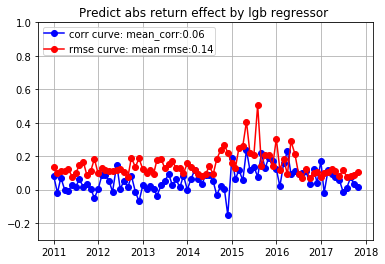

In [24]:
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

def get_test_corr(filename):

    df = pd.read_csv(filename)

    corr_list = []  #保存每个月份的准确率
    rmse_list = []
    for date, group in df.groupby('tradeDate'):
        a = np.array(group['factor'].values)
        b = np.array(group['abs_return'].values)
        corr = np.corrcoef(a,b)[0,1]
        corr_list.append([date, corr])
        rmse = np.sqrt(mean_squared_error(a,b))
        rmse_list.append([date, rmse])
        
    corr_list = sorted(corr_list, key=lambda x: x[0], reverse=False)
    rmse_list = sorted(rmse_list, key=lambda x: x[0], reverse=False)
    mean_corr = sum([item[1] for item in corr_list]) / len(corr_list)
    mean_rmse = sum([item[1] for item in rmse_list]) / len(rmse_list)
     
    return corr_list,rmse_list,round(mean_corr, 2),round(mean_rmse ,2)

def plot_accuracy_curve(filename):
    '''
    画图
    '''
    corr_list,rmse_list,mean_corr,mean_rmse  = get_test_corr(filename)

    plt.plot([datetime.strptime(str(item[0]), '%Y%m%d') for item in corr_list], [item[1] for item in corr_list], '-bo')
    plt.plot([datetime.strptime(str(item[0]), '%Y%m%d') for item in rmse_list], [item[1] for item in rmse_list], '-ro')
    
    plt.legend([u"corr curve: mean_corr:%s"%mean_corr, u"rmse curve: mean rmse:%s"%mean_rmse], loc='upper left', handlelength=2, handletextpad=0.5, borderpad=0.1)
    plt.ylim((-0.3, 1))
    plt.title('Predict abs return effect by lgb regressor ')
    plt.grid(True)
    plt.show()


plot_accuracy_curve( "lgbr_abs.csv")